# RAG Project - Karina K - Experiments

1. First, you will need a database to experiment with. The RAG project uses LanceDB, as described in the config file. In this task, you’ll work with the documentation of the transformers library. Download the markdown_to_text.py file to your VM. Clone https://github.com/huggingface/transformers to your VM and run markdown_to_text.py script to extract raw text from transformers/docs/source/en/. This is the script you need to run: python prep_scripts/markdown_to_text.py --input-dir transformers/docs/source/en/ --output-dir docs This will be your knowledge base, you don't need it to be a part of your repository. Use the add_to_rag_db endpoint to load every text into the database. Make several RAG API calls to check that the pipeline is working.

In [5]:
import os  
import requests  
import pandas as pd  
import time  
  
  
token = os.getenv("YOUR_TOKEN")  
if not token:  
    raise EnvironmentError("Environment variable 'YOUR_TOKEN' is not set.")  
   
url = "http://localhost:8001/rag/"  

def perform_rag_request(query, model="gpt-4o-mini", use_reranker=False, top_k_retrieve=20, top_k_rank=4, max_out_tokens=512):  
    payload = {  
        "query": query,  
        "model": model,  
        "use_reranker": use_reranker,  
        "top_k_retrieve": top_k_retrieve,  
        "top_k_rank": top_k_rank,  
        "max_out_tokens": max_out_tokens  
    }  
  
    headers = {  
        "accept": "application/json",  
        "Authorization": token,  
        "Content-Type": "application/json"  
    }  
  
    start_time = time.time()  
    response = requests.post(url, json=payload, headers=headers)  
    response_time = time.time() - start_time  
  
    if response.status_code == 200:  
        response_json = response.json()  
        answer = response_json.get("response", "No answer provided")  
    else:  
        answer = f"Error: {response.status_code}, {response.text}"  
  
    return answer, response_time  
  

query = "What is the Segment Anything Model (SAM)?"  
  
answer, response_time = perform_rag_request(query)  
print(f"Answer: {answer}\n\nResponse Time: {response_time:.2f} seconds")  

Answer: The Segment Anything Model (SAM) is a state-of-the-art model for image segmentation, designed to predict segmentation masks of any object of interest given an input image. It was proposed in the paper "Segment Anything" by a team of researchers. SAM is part of the Segment Anything (SA) project, which introduces a new task, model, and dataset for image segmentation.

The model is trained to be promptable, meaning it can adapt to new image distributions and tasks without requiring additional training (zero-shot capability). SAM was evaluated across various tasks and demonstrated impressive zero-shot performance, often competitive with or superior to prior fully supervised results.

The model is built on a foundation dataset called SA-1B, which contains over 1 billion masks on 11 million licensed and privacy-respecting images. SAM consists of a Vision Transformer-based image encoder, a prompt encoder, and a two-way transformer mask decoder, allowing it to generate valid segmentati

2. Try using a reranker. The reranker is defined in the rerank: container_name: rerank_service image: [ghcr.io/huggingface/text-embeddings-inference:cpu-1.5](http://ghcr.io/huggingface/text-embeddings-inference:cpu-1.5) volumes: - ./data:/data command: ["--model-id", "mixedbread-ai/mxbai-rerank-base-v1"] part of rag_service/docker-compose.yaml. As you can see, the defalt reranker is mixedbread-ai/mxbai-rerank-base-v1. However, by default it is not used, which is established by the parameter use_reranker: bool = False of the constructor class RAGRequest(BaseModel) in the file rag_service/src/main.py. You need to make it True to switch on reranking. Also, you can change the parameters top_k_retrieve, top_k_rank , if necessary.

The deliverables if this stage are:
- A comparison of how the retrieved context changes after adding a reranker. Try at least 10 different prompts.
- Measure the responce time for RAG with and without a reranker for at least 10 different prompts and for at least 3 different values of top_k_rank.
- The analysis of pros and cons of using a reranker. The evaluation aspects should include the relevance of the top-k documents and the response time.

In [8]:
questions_dataset_10 = [
    {"doc": "main_classes_agent.txt",
     "question": "What are the key differences between `CodeAgent` and `ReactAgent`?",
     "answer": """The key differences between `CodeAgent` and `ReactAgent` are:  
   
1. **Execution Method**:  
   - `CodeAgent`: Executes in one shot. It generates the code to solve the task and executes it all at once.  
   - `ReactAgent`: Operates step by step. Each step consists of one thought, followed by one tool call and execution.  
   
2. **Types of `ReactAgent`**:  
   - `ReactJsonAgent`: Writes its tool calls in JSON.  
   - `ReactCodeAgent`: Writes its tool calls in Python code.   
  
These differences highlight the approach and granularity with which each agent type handles tasks and tool executions."""},
    {"doc": "_generation_strategies.txt",
     "question": "How does the `generate` method work in different modalities?",
     "answer": """The `generate` method works differently in various modalities by relying on the specific inputs provided by the model's preprocessor class. The inputs to the `generate` method depend on the model's modality, and they are returned by the model's preprocessor class, such as `AutoTokenizer` or `AutoProcessor`. If a model's preprocessor creates more than one kind of input, all the inputs should be passed to the `generate` method. This ensures that the method can produce appropriate text outputs for different tasks, such as text summarization, image captioning, and audio transcription."""},
    {"doc": "model_doc_dit.txt",
     "question": "How can one load a fine-tuned model of DiT from the hub for document image classification?",
     "answer": """You can load a fine-tuned model of DiT from the hub for document image classification using the following code:  
   
```python  
from transformers import AutoModelForImageClassification  
model = AutoModelForImageClassification.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")  
```  
   
This particular checkpoint was fine-tuned on RVL-CDIP, an important benchmark for document image classification."""},
    {"doc": "_perplexity.txt",
     "question": "How does the tokenization procedure impact a model's perplexity?",
     "answer": """The tokenization procedure has a direct impact on a model's perplexity because perplexity is defined as the exponentiated average negative log-likelihood of a sequence. Since the log-likelihood is calculated for each token in the sequence, the way the sequence is tokenized will affect the likelihoods and thus the perplexity. This should always be taken into consideration when comparing different models."""},
    {"doc": "model_doc_falcon.txt",
     "question": "What change has been made regarding Falcon models on the Hugging Face Hub?",
     "answer": """Falcon models were initially added to the Hugging Face Hub as custom code checkpoints. However, Falcon is now fully supported in the Transformers library."""},
    {"doc": "quantization_awq.txt",
         "question": "Why doesn't AWQ quantize all the weights in a model?",
         "answer": """AWQ doesn't quantize all the weights in a model because it preserves a small percentage of weights that are important for LLM performance. This significantly reduces quantization loss such that you can run models in 4-bit precision without experiencing any performance degradation."""},
    {"doc": "tasks_knowledge_distillation_for_image_classification.txt",
         "question": "How is the performance of the distilled model evaluated?",
         "answer": """The performance of the distilled model is evaluated using the compute_metrics function, which computes the accuracy and F1 score of the model on the test set. Specifically, the accuracy is calculated by comparing the model's predictions to the true labels. During the training process, this function is used to assess the model's performance, and the final evaluation is conducted on the test set using the trainer.evaluate(processed_datasets["test"]) method. The distilled model achieved 72 percent accuracy on the test set."""},
    {"doc": "model_doc_starcoder2.txt",
         "question": "What is Grouped Query Attention and how is it used in StarCoder2?",
         "answer": """Grouped Query Attention is a technique used in the StarCoder2 models. All models in the StarCoder2 family utilize this technique, although the text does not provide detailed specifics on its implementation or functionality."""},
    {"doc": "_perf_hardware.txt",
         "question": "What temperature range is considered good for a GPU under heavy load?",
         "answer": """'s hard to tell the exact best temperature to strive for when a GPU is heavily loaded, but probably anything under +80C is good, but lower is better - perhaps 70-75C is an excellent range to be in."""},
    {"doc": "_attention.txt",
         "question": "What is LSH attention and how does it work in the Reformer model?",
         "answer": """LSH attention in the Reformer model works by focusing only on the largest elements in the softmax(QK^t) matrix, which are the most useful contributions. For each query  q in Q , only the keys  k  in K  that are close to  q  are considered. A hash function is used to determine if q  and k  are close. The attention mask is modified to mask the current token (except at the first position) to prevent the query and key from being equal. Since the hash can be somewhat random, several hash functions (determined by a n_rounds parameter) are used and averaged together."""},
]
len(questions_dataset_10)

10

In [12]:
import pandas as pd  
import matplotlib.pyplot as plt  
 

top_k_rank_values = [4, 7, 10]  
  
# Perform requests and save results  
results = {  
    "without_reranker": [],  
    "with_reranker_top_k_rank_4": [],  
    "with_reranker_top_k_rank_7": [],  
    "with_reranker_top_k_rank_10": []  
}  
  
# Without reranker  
for entry in questions_dataset_10:  
    question = entry["question"]  
    groundtruth_answer = entry["answer"]  
      
    answer, response_time = perform_rag_request(query=question, use_reranker=False)  
    results["without_reranker"].append({  
        "question": question,  
        "groundtruth_answer": groundtruth_answer,  
        "actual_answer": answer,  
        "response_time_s": response_time,  
        "use_reranker": False,  
        "top_k_rank": None  
    })  
  
# With reranker    
for entry in questions_dataset_10:  
    question = entry["question"]  
    groundtruth_answer = entry["answer"]  
      
    for top_k_rank in top_k_rank_values:  
        answer, response_time = perform_rag_request(query=question, use_reranker=True, top_k_rank=top_k_rank)  
        results[f"with_reranker_top_k_rank_{top_k_rank}"].append({  
            "question": question,  
            "groundtruth_answer": groundtruth_answer,  
            "actual_answer": answer,  
            "response_time_s": response_time,  
            "use_reranker": True,  
            "top_k_rank": top_k_rank  
        })  
  

In [15]:
for key, result in results.items():  
    df = pd.DataFrame(result)  
    df.to_csv(f"results_{key}.csv", index=False)  
        
    print(f"\nStatistics for {key.replace('_', ' ').title()}:")  
    print(f"Min Response Time: {df['response_time_s'].min():.2f} seconds")  
    print(f"Max Response Time: {df['response_time_s'].max():.2f} seconds")  
    print(f"Mean Response Time: {df['response_time_s'].mean():.2f} seconds")  
    print(f"Median Response Time: {df['response_time_s'].median():.2f} seconds")  


Statistics for Without Reranker:
Min Response Time: 1.60 seconds
Max Response Time: 5.83 seconds
Mean Response Time: 3.01 seconds
Median Response Time: 2.50 seconds

Statistics for With Reranker Top K Rank 4:
Min Response Time: 21.70 seconds
Max Response Time: 31.65 seconds
Mean Response Time: 26.83 seconds
Median Response Time: 26.62 seconds

Statistics for With Reranker Top K Rank 7:
Min Response Time: 21.64 seconds
Max Response Time: 30.72 seconds
Mean Response Time: 27.63 seconds
Median Response Time: 28.41 seconds

Statistics for With Reranker Top K Rank 10:
Min Response Time: 22.60 seconds
Max Response Time: 33.18 seconds
Mean Response Time: 27.80 seconds
Median Response Time: 28.05 seconds


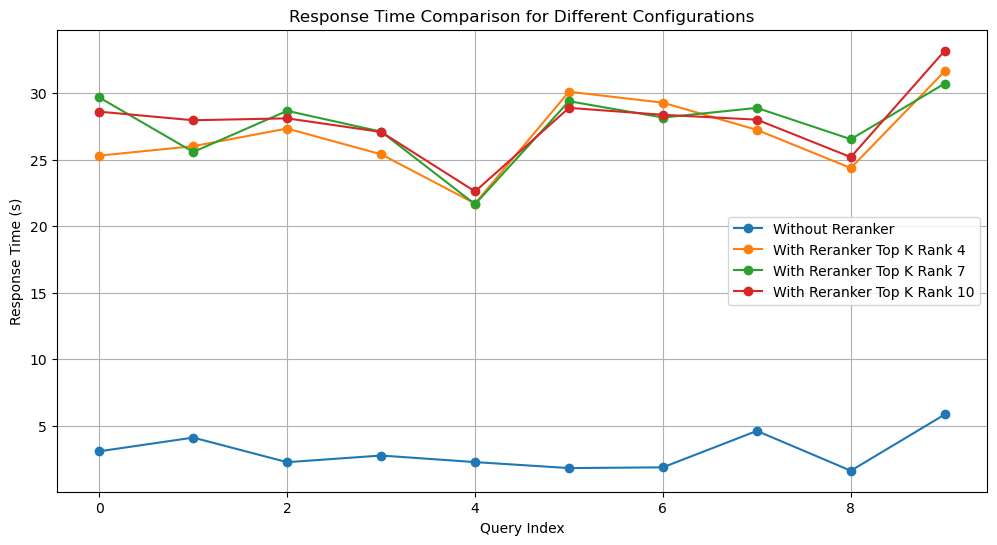

In [14]:
# Save results and print statistics  
plt.figure(figsize=(12, 6))  
for key, result in results.items():  
    df = pd.DataFrame(result)  
    plt.plot(df["response_time_s"], label=key.replace('_', ' ').title(), marker='o')  
  
plt.xlabel("Query Index")  
plt.ylabel("Response Time (s)")  
plt.title("Response Time Comparison for Different Configurations")  
plt.legend()  
plt.grid(True)  
plt.savefig("response_times_comparison.png")  
plt.show()  

**The deliverables:**

2.1) **A comparison of how the retrieved context changes after adding a reranker. Try at least 10 different prompts.**

I compared answers to questions with and without using a reranker, utilizing GPT-4o-mini. I prepared a dataset with 10 different requests based on our knowledge database and hardcoded them.

Quality of answers: All answers turned out to be quite similar and aligned with the ground truth. Let's look at a few examples (without reranker and with top-k=7). They are almost identical and similar to the ground truth:



In [23]:
example_indices = [0, 1, 2] 
for i in example_indices:  
    print(f"\nExample {i + 1}:")  
    print(f"Question: {questions_dataset_10[i]['question']}")  
    print(f"Groundtruth Answer: \n{questions_dataset_10[i]['answer']}\n")  
      
    without_reranker_answer = results["without_reranker"][i]["actual_answer"]  
    with_reranker_top_k_7_answer = results["with_reranker_top_k_rank_7"][i]["actual_answer"]  
    print("\n" + "-"*50)    
    print("Without Reranker Answer:")  
    print(without_reranker_answer)  
    print("\n" + "-"*50)  
    print("\nWith Reranker (top-k=7) Answer:")  
    print(with_reranker_top_k_7_answer)  
    print("\n" + "-"*50)  


Example 1:
Question: What are the key differences between `CodeAgent` and `ReactAgent`?
Groundtruth Answer: 
The key differences between `CodeAgent` and `ReactAgent` are:  
   
1. **Execution Method**:  
   - `CodeAgent`: Executes in one shot. It generates the code to solve the task and executes it all at once.  
   - `ReactAgent`: Operates step by step. Each step consists of one thought, followed by one tool call and execution.  
   
2. **Types of `ReactAgent`**:  
   - `ReactJsonAgent`: Writes its tool calls in JSON.  
   - `ReactCodeAgent`: Writes its tool calls in Python code.   
  
These differences highlight the approach and granularity with which each agent type handles tasks and tool executions.


--------------------------------------------------
Without Reranker Answer:
The key differences between `CodeAgent` and `ReactAgent` are:

1. **Execution Style**:
   - `CodeAgent` acts in one shot, generating code to solve the task and executing it at once.
   - `ReactAgent` acts ste


2.2) **Measure the response time for RAG with and without a reranker for at least 10 different prompts and for at least 3 different values of top_k_rank.**

I compared the response time; you can see the statistics and plots above. For the approach without using a reranker, the response time is, of course, much shorter than when using one. However, for Top-k values of 4, 7, and 10, there is almost no difference.



2.3) **The analysis of pros and cons of using a reranker. The evaluation aspects should include the relevance of the top-k documents and the response time.**

Unfortunately, I used the RAG endpoint, and the response does not contain top-k documents, so I can only judge by the quality of the answers. They seem to be pretty close for all four scenarios I tested. Regarding time, I do not see a significant difference when using top-k values of 4, 7, or 10. You can see that they are almost similar. Probably, the mean and median response times are slightly less for top-k=4. In this experiment, I do not see any advantages of using a reranker, and in the future, I will not use it to save time.


In general:

Pros:
- Reranker can improve the relevance of the top-k documents, leading to more accurate and useful results.

Cons:
- Usage of a reranker  increases the overall response time due to the additional processing required.
- More computational resources are needed to rerank the documents, which can lead to higher operational costs.

**3. Try at least three different LLMs and compare the results.** At least one of them should be called using Nebius AI Studio API. The deliverables are:
- Analysis of the differences between outputs and conclusions from the analysis. Try at least 10 different prompts for each LLM.

I've added llama-3.1 container
```
  llama-3.1:
    build: ./inference_service
    container_name: inference_service_llama
    ports:
      - "8004:8000"
    environment:
      BASE_URL: "https://api.studio.nebius.ai/v1/"
      OPENAI_API_KEY: ${NEBIUS_API_KEY}
      MODEL_NAME: "meta-llama/Meta-Llama-3.1-70B-Instruct"
```

So I would use 3 models: **gpt-4o, gpt-4o-mini, llama-3.1-70B (Nebius AI Studio API)**

I will analyze the differences between the outputs and present the conclusions from the analysis in the next part.

**4. Put together a simple evaluation dataset of 20 questions (+optionally answers)** - you could do it manually or generate with an LLM. Use the LLM-as-a-Judge approach to quantitatively evaluate your best setup. 

 [Bonus] Explore the Ragas docs for possible evaluation setups.

 The deliverables are:

- Your evaluation set and how you created it
- The evaluation setup (which LLM you used as a judge, what was the evaluation prompt etc)
- Evaluation results (quantitative metics and conclusions are required)

In [6]:
# Evaluation set

questions_dataset_20 = [
    {"doc": "main_classes_agent.txt",
     "question": "What are the key differences between `CodeAgent` and `ReactAgent`?",
     "answer": """The key differences between `CodeAgent` and `ReactAgent` are:  
   
1. **Execution Method**:  
   - `CodeAgent`: Executes in one shot. It generates the code to solve the task and executes it all at once.  
   - `ReactAgent`: Operates step by step. Each step consists of one thought, followed by one tool call and execution.  
   
2. **Types of `ReactAgent`**:  
   - `ReactJsonAgent`: Writes its tool calls in JSON.  
   - `ReactCodeAgent`: Writes its tool calls in Python code.   
  
These differences highlight the approach and granularity with which each agent type handles tasks and tool executions."""},
    {"doc": "_generation_strategies.txt",
     "question": "How does the `generate` method work in different modalities?",
     "answer": """The `generate` method works differently in various modalities by relying on the specific inputs provided by the model's preprocessor class. The inputs to the `generate` method depend on the model's modality, and they are returned by the model's preprocessor class, such as `AutoTokenizer` or `AutoProcessor`. If a model's preprocessor creates more than one kind of input, all the inputs should be passed to the `generate` method. This ensures that the method can produce appropriate text outputs for different tasks, such as text summarization, image captioning, and audio transcription."""},
    {"doc": "model_doc_dit.txt",
     "question": "How can one load a fine-tuned model of DiT from the hub for document image classification?",
     "answer": """You can load a fine-tuned model of DiT from the hub for document image classification using the following code:  
   
```python  
from transformers import AutoModelForImageClassification  
model = AutoModelForImageClassification.from_pretrained("microsoft/dit-base-finetuned-rvlcdip")  
```  
   
This particular checkpoint was fine-tuned on RVL-CDIP, an important benchmark for document image classification."""},
    {"doc": "_perplexity.txt",
     "question": "How does the tokenization procedure impact a model's perplexity?",
     "answer": """The tokenization procedure has a direct impact on a model's perplexity because perplexity is defined as the exponentiated average negative log-likelihood of a sequence. Since the log-likelihood is calculated for each token in the sequence, the way the sequence is tokenized will affect the likelihoods and thus the perplexity. This should always be taken into consideration when comparing different models."""},
    {"doc": "model_doc_falcon.txt",
     "question": "What change has been made regarding Falcon models on the Hugging Face Hub?",
     "answer": """Falcon models were initially added to the Hugging Face Hub as custom code checkpoints. However, Falcon is now fully supported in the Transformers library."""},
    {"doc": "quantization_awq.txt",
         "question": "Why doesn't AWQ quantize all the weights in a model?",
         "answer": """AWQ doesn't quantize all the weights in a model because it preserves a small percentage of weights that are important for LLM performance. This significantly reduces quantization loss such that you can run models in 4-bit precision without experiencing any performance degradation."""},
    {"doc": "tasks_knowledge_distillation_for_image_classification.txt",
         "question": "How is the performance of the distilled model evaluated?",
         "answer": """The performance of the distilled model is evaluated using the compute_metrics function, which computes the accuracy and F1 score of the model on the test set. Specifically, the accuracy is calculated by comparing the model's predictions to the true labels. During the training process, this function is used to assess the model's performance, and the final evaluation is conducted on the test set using the trainer.evaluate(processed_datasets["test"]) method. The distilled model achieved 72 percent accuracy on the test set."""},
    {"doc": "model_doc_starcoder2.txt",
         "question": "What is Grouped Query Attention and how is it used in StarCoder2?",
         "answer": """Grouped Query Attention is a technique used in the StarCoder2 models. All models in the StarCoder2 family utilize this technique, although the text does not provide detailed specifics on its implementation or functionality."""},
    {"doc": "_perf_hardware.txt",
         "question": "What temperature range is considered good for a GPU under heavy load?",
         "answer": """'s hard to tell the exact best temperature to strive for when a GPU is heavily loaded, but probably anything under +80C is good, but lower is better - perhaps 70-75C is an excellent range to be in."""},
    {"doc": "_attention.txt",
         "question": "What is LSH attention and how does it work in the Reformer model?",
         "answer": """LSH attention in the Reformer model works by focusing only on the largest elements in the softmax(QK^t) matrix, which are the most useful contributions. For each query  q in Q , only the keys  k  in K  that are close to  q  are considered. A hash function is used to determine if q  and k  are close. The attention mask is modified to mask the current token (except at the first position) to prevent the query and key from being equal. Since the hash can be somewhat random, several hash functions (determined by a n_rounds parameter) are used and averaged together."""},
    {
        "doc": "_accelerate.txt",
        "question": "What is the key modification made to the typical PyTorch training loop when using Huggingface  Accelerate?",
        "answer": """The key modification made to the typical PyTorch training loop when using Huggingface Accelerate is to replace the standard `loss.backward()` call with Huggingface Accelerate's `accelerator.backward(loss)` method. This change enables the distributed training functionalities provided by the library."""
    },
    {
        "doc": "_benchmarks.txt",
        "question": "What additional information is provided in the ENVIRONMENT INFORMATION section of the benchmark results?",
        "answer": """The ENVIRONMENT INFORMATION section of the benchmark results provides the following additional information:  
   
- `transformers_version`  
- `framework`  
- `use_torchscript` (for PyTorch) or `use_xla` (for TensorFlow)  
- `framework_version`  
- `python_version`  
- `system`  
- `cpu`  
- `architecture`  
- `date`  
- `time`  
- `fp16`  
- `use_multiprocessing`  
- `only_pretrain_model`  
- `cpu_ram_mb`  
- `use_gpu`  
- `num_gpus`  
- `gpu`  
- `gpu_ram_mb`  
- `gpu_power_watts`  
- `gpu_performance_state`  
- `use_tpu`"""
    },
    {
        "doc": "_contributing.txt",
        "question": "How can you sync a forked repository with the upstream main branch without creating unnecessary notifications?",
        "answer": """When updating the main branch of a forked repository, please follow these steps to avoid pinging the upstream repository which adds reference notes to each upstream PR, and sends unnecessary notifications to the developers involved in these PRs.  
   
When possible, avoid syncing with the upstream using a branch and PR on the forked repository. Instead, merge directly into the forked main. If a PR is absolutely necessary, use the following steps after checking out your branch:  
1. `git checkout -b your-branch-for-syncing`  
2. `git pull --squash --no-commit upstream main`  
3. `git commit -m '<your message without GitHub references>'`  
4. `git push --set-upstream origin your-branch-for-syncing`"""
    },
    {
        "doc": "main_classes_data_collator.txt",
        "question": "What types of token masking are mentioned for DataCollatorForLanguageModeling?",
        "answer": """The types of token masking mentioned for DataCollatorForLanguageModeling are:  
- numpy_mask_tokens  
- tf_mask_tokens  
- torch_mask_tokens"""
    },
    {
        "doc": "main_classes_onnx.txt",
        "question": "Which abstract class should decoder-based models inherit from for ONNX export?",
        "answer": """Decoder-based models inherit from [~onnx.config.OnnxConfigWithPast]."""
    },
    {
        "doc": "model_doc_audio-spectrogram-transformer.txt",
        "question": "How does the Audio Spectrogram Transformer model differ from traditional audio classification models?",
        "answer": """The Audio Spectrogram Transformer (AST) model differs from traditional audio classification models by being purely attention-based and convolution-free. Traditional models often use convolutional neural networks (CNNs) as the main building block, sometimes with an added self-attention mechanism on top to capture long-range global context. The AST, however, does not rely on CNNs at all and instead uses a Vision Transformer applied to audio by turning audio into a spectrogram, achieving state-of-the-art results for audio classification."""
    },
    {
        "doc": "model_doc_bridgetower.txt",
        "question": "Are there any specific requirements for running the PyTorch version of the BridgeTower model?",
        "answer": """Yes, the PyTorch version of the BridgeTower model is only available in torch 1.10 and higher."""
    },
    {
        "doc": "model_doc_cpm.txt",
        "question": "What kind of tokenization method does CPM use?",
        "answer": """CPM's architecture is the same as GPT-2, except for tokenization method."""
    },
    {
        "doc": "model_doc_flan-ul2.txt",
        "question": "How many additional training steps were performed on UL2 20B before applying Flan instruction tuning?",
        "answer": """An additional 100k steps were performed on UL2 20B before applying Flan instruction tuning."""
    },
    {
        "doc": "tasks_mask_generation.txt",
        "question": "What is the Segment Anything Model (SAM)?",
        "answer": """The Segment Anything Model (SAM) is a powerful model that supports the mask generation task. It consists of a Vision Transformer-based image encoder, a prompt encoder, and a two-way transformer mask decoder. SAM is trained on a large dataset called SA-1B, which contains 1 million images and 1.1 billion masks. It serves as a powerful foundation model for segmentation due to its large data coverage."""
    },


]

In [22]:
import openai  
import json

openai.api_key = os.environ["OPENAI_API_KEY"] 

def evaluate_answer(question, ground_truth, answer):
    
    # This prompts I used in my work in Azure Prompt Flow. It worked pretty well with GPT-4-Turbo
    system_message = (
        "You are an AI assistant. You will be given the definition of an evaluation metric for "
        "assessing the quality of an answer in a question-answering task. Your job is to compute an "
        "accurate evaluation score using the provided evaluation metric."
    )

    user_message = f"""
    Equivalence, as a metric, measures the similarity between the predicted answer and the correct answer. 
    If the information and content in the predicted answer is similar or equivalent to the correct answer, 
    then the value of the Equivalence metric should be high, else it should be low. Given the question, 
    correct answer, and predicted answer, determine the value of Equivalence metric using the following rating scale:
    One star: the predicted answer is not at all similar to the correct answer
    Two stars: the predicted answer is mostly not similar to the correct answer
    Three stars: the predicted answer is somewhat similar to the correct answer
    Four stars: the predicted answer is mostly similar to the correct answer
    Five stars: the predicted answer is completely similar to the correct answer

    This rating value should always be an integer between 1 and 5. So the rating produced should be 1 or 2 or 3 or 4 or 5.

    question: {question}
    correct answer: {ground_truth}
    predicted answer: {answer}

    Evaluate only the similarity of the meanings of predicted answer and correct answer.

    Desired response format <json>:

    {{
      "explanation": <str> concise explanation of the number of rating stars given,
      "stars": <int> value
    }}
    """
    response = openai.chat.completions.create(
        model="gpt-4o-mini",
        
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": user_message}
        ],
        response_format={"type": "json_object"}
    )
    return response.choices[0].message.content


if __name__ == "__main__":
    question = "What is the capital of France?"
    ground_truth = "Paris"
    answer = "Paris is the capital city of France."

    evaluation = evaluate_answer(question, ground_truth, answer)
    print("Evaluation Result:")
    print(json.loads(evaluation))


Evaluation Result:
{'explanation': 'The predicted answer restates the correct answer with additional context but retains the same essential meaning, making it completely similar.', 'stars': 5}


In [27]:
from tqdm import tqdm 
import csv

for model in ["gpt-4o", "gpt-4o-mini", "llama-3.1"]:
    results = []
    total_stars = 0
    
    for question_data in tqdm(questions_dataset_20):
        question = question_data["question"]
        ground_truth = question_data["answer"]
    
        actual_answer, response_time = perform_rag_request(query=question, model=model, use_reranker=False)
    
        evaluation = evaluate_answer(question, ground_truth, actual_answer)
        json_data = json.loads((evaluation)) 
        explanation = json_data["explanation"]
        stars = json_data["stars"]
    
        total_stars += stars
    
        results.append({
            "question": question,
            "groundtruth_answer": ground_truth,
            "actual_answer": actual_answer,
            "response_time_s": response_time,
            "explanation": explanation,
            "stars": stars
        })
    
    # Save results to csv
    csv_filename = f"results_{model.replace(".", "_").replace("-", "_")}.csv"
    with open(csv_filename, "w", newline="", encoding="utf-8") as csvfile:
        fieldnames = ["question", "groundtruth_answer", "actual_answer", "response_time_s", "explanation", "stars"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)
    
    print(f"{model} results:")
    average_stars = total_stars / len(questions_dataset_20)
    print(f"Avarage score: {average_stars:.2f}")
    print(f"Results saved to {csv_filename}")
    print("\n" + "-"*50) 

    # low-score results
    print(f"\nLow-score results for {model} (3 stars or less):")
    low_score_results = [result for result in results if result["stars"] <= 3]
    for result in low_score_results:
        print(f"\nQuestion: {result['question']}")
        print(f"Groundtruth Answer: {result['groundtruth_answer']}")
        print(f"Actual Answer: {result['actual_answer']}")
        print(f"Stars: {result['stars']}")
        print(f"Explanation: {result['explanation']}")
    print("-" * 50)
    print("\n\n")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:01<00:00,  6.05s/it]


gpt-4o results:
Avarage score: 4.10
Results saved to results_gpt_4o.csv

--------------------------------------------------

Low-score results for gpt-4o (3 stars or less):

Question: How does the `generate` method work in different modalities?
Groundtruth Answer: The `generate` method works differently in various modalities by relying on the specific inputs provided by the model's preprocessor class. The inputs to the `generate` method depend on the model's modality, and they are returned by the model's preprocessor class, such as `AutoTokenizer` or `AutoProcessor`. If a model's preprocessor creates more than one kind of input, all the inputs should be passed to the `generate` method. This ensures that the method can produce appropriate text outputs for different tasks, such as text summarization, image captioning, and audio transcription.
Actual Answer: The context provided doesn't specifically detail how the `generate` method works across different modalities. It primarily focuses o

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.35s/it]


gpt-4o-mini results:
Avarage score: 4.10
Results saved to results_gpt_4o_mini.csv

--------------------------------------------------

Low-score results for gpt-4o-mini (3 stars or less):

Question: How does the `generate` method work in different modalities?
Groundtruth Answer: The `generate` method works differently in various modalities by relying on the specific inputs provided by the model's preprocessor class. The inputs to the `generate` method depend on the model's modality, and they are returned by the model's preprocessor class, such as `AutoTokenizer` or `AutoProcessor`. If a model's preprocessor creates more than one kind of input, all the inputs should be passed to the `generate` method. This ensures that the method can produce appropriate text outputs for different tasks, such as text summarization, image captioning, and audio transcription.
Actual Answer: The `generate` method works differently depending on the task and the chosen decoding strategy (such as greedy decodi

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:39<00:00,  5.00s/it]

llama-3.1 results:
Avarage score: 4.00
Results saved to results_llama_3_1.csv

--------------------------------------------------

Low-score results for llama-3.1 (3 stars or less):

Question: How does the `generate` method work in different modalities?
Groundtruth Answer: The `generate` method works differently in various modalities by relying on the specific inputs provided by the model's preprocessor class. The inputs to the `generate` method depend on the model's modality, and they are returned by the model's preprocessor class, such as `AutoTokenizer` or `AutoProcessor`. If a model's preprocessor creates more than one kind of input, all the inputs should be passed to the `generate` method. This ensures that the method can produce appropriate text outputs for different tasks, such as text summarization, image captioning, and audio transcription.
Actual Answer: The `generate` method works differently in different modalities. For input-grounded tasks like audio transcription or trans

**The deliverables:**

3) (the previous task) **Analysis of the differences between outputs and conclusions from the analysis. Try at least 10 different prompts for each LLM.**

In the responses from LLAMA 3.1, phrases like "Based on the provided context", "According to the text" or "According to the context documents" are frequently observed. It is necessary to rewrite the prompt based on the model. Overall, the answers from all models are adequate. Of course, the answers from gpt 4o and gpt 4o mini are more similar and, for this task, can even be considered identical.
 

llama 3.1
> According to the provided context, Activation-aware Weight Quantization (AWQ) doesn't quantize all the weights in a model because it preserves a small percentage of weights that are important for LLM performance, which significantly reduces quantization loss.

gpt-4o
> AWQ doesn't quantize all the weights in a model because it aims to preserve a small percentage of weights that are important for the performance of large language models (LLMs). This selective approach significantly reduces quantization loss, allowing models to run in 4-bit precision without experiencing any performance degradation.

gpt-4o-mini
>  AWQ doesn't quantize all the weights in a model because it preserves a small percentage of weights that are important for LLM performance. This significantly reduces quantization loss such that you can run models in 4-bit precision without experiencing any performance degradation.

4.1) **Your evaluation set and how you created it**

My evaluation dataset contains 20 questions. I created it manually by selecting a random document and sending its text to GPT-4o with the prompt "Ask questions about this text {text}". Then, I chose one of the questions and sent it back with the text "Answer this question using only the text above {question}". In this way, I compiled 20 questions.

4.2) **The evaluation setup (which LLM you used as a judge, what was the evaluation prompt etc)**

Please see the prompt above. There is an improved evaluation prompt from Azure Prompt Flow. I use GPT-4o-mini for cost efficiency. In real-life scenarios, I would not use the same model for evaluation as I used for text generation.

4.3) Evaluation results (quantitative metics and conclusions are required)

Metrics:
-  **4.1/5 gpt-4o**. 4 tests out of 20 did not pass (less than 3 stars)
- **4.1/5 gpt-4o-mini**. 5 tests out of 20 did not pass (less then 3 stars)
- **4/5 llama-3.1-70b**. 8 tests out of 20 did not pass (less then 3 stars)

Conclusion:
1) The answers from LLAMA are more reserved and often contain phrases like "Based on the provided context," so I would definitely rewrite the prompt for using this model. Most tests did not pass for LLAMA.
2) All answers are adequate, especially for GPT. For cost-saving purposes, I would use the mini model. However, testing and protection against prompt injections are necessary. In the chatbot for internal documentation at my workplace, I used GPT-4o and a complex prompt that protects against improper use, i.e., providing information not contained in the retrieves texts. But without experiments I am not sure if the same quality can be achieved with the mini model.


**Task 5.** Try a different embedding model from the top of the MTEB leaderboard and justify your choice. If things are getting slow, switch to a gpu - don’t forget to switch to a corresponding tei container.

 The encoder is defined in this part

 embed:
     container_name: embed_service
     image: [ghcr.io/huggingface/text-embeddings-inference:cpu-1.5](http://ghcr.io/huggingface/text-embeddings-inference:cpu-1.5)
     volumes:
         - ./data:/data
     command: ["--model-id", "BAAI/bge-small-en-v1.5"]

 of rag_service/docker-compose.yaml. As you can see, the defalt encoder is BAAI/bge-small-en-v1.5.

 The deliverables are:

- Which alternative embedding model you tried and why.
- The analysis of how retrieved documents differ between embedding models (is one better than the other?)
- The analysis of how the embedding time differs between models.

In progress

**5.1. Which alternative embedding model you tried and why.**

**5.3. The analysis of how the embedding time differs between models.**

For **8BAAI/bge-small-en-v1.5** 30 minuts was adding all the documentation to DB. Model size *33.4M* params


I have chosen  **Alibaba-NLP/gte-base-en-v1.5**, because it has onnx model and this model is larger.  
Model size *137M params*
Adding the same chunks to DB last 1h 36min. Of course because this model is larger in 4 times. 


Let's now repeat an experiment with reranker, now we would not use it, just check time of answers and evaluate them.



For **8BAAI/bge-small-en-v1.5**, it took 30 minutes to add all the documentation to the database. The model size is *33.4M parameters*.

I have chosen **Alibaba-NLP/gte-base-en-v1.5** because it has an ONNX model and is larger. The model size is *137M parameters*. Adding the same chunks to the database took 1h 36 min, understandably because this model is 4 times larger.

Let's now repeat the experiment without using the reranker. We will just check the response times and evaluate the answers.

In [32]:
results = []  
total_stars = 0
  
for entry in questions_dataset_20:  
    question = entry["question"]  
    groundtruth_answer = entry["answer"]  
      
    actual_answer, response_time = perform_rag_request(query=question)  
    evaluation = evaluate_answer(question, groundtruth_answer, actual_answer)  
    json_data = json.loads(evaluation)  
    explanation = json_data["explanation"]  
    stars = json_data["stars"]  
      
    total_stars += stars  
    results.append({  
        "question": question,  
        "groundtruth_answer": groundtruth_answer,  
        "actual_answer": actual_answer,  
        "response_time_s": response_time,  
        "explanation": explanation,  
        "stars": stars  
    })  
  
df = pd.DataFrame(results)  
df.to_csv("results_without_reranker_Alibaba_NLP_embed.csv", index=False)  
  



Statistics for Without Reranker for Alibaba-NLP/gte-base-en-v1.5 embeding model:
Min Response Time: 1.75 seconds
Max Response Time: 5.80 seconds
Mean Response Time: 3.17 seconds
Median Response Time: 2.63 seconds


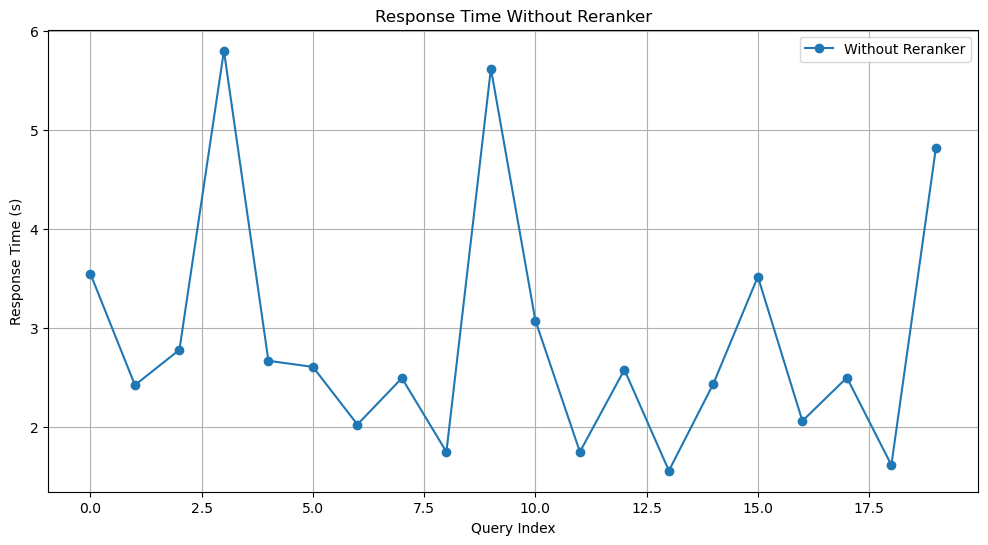


Average Stars: 3.95 out of 5


In [38]:
import matplotlib.pyplot as plt  
 

plt.figure(figsize=(12, 6))  
plt.plot(df["response_time_s"], label="Without Reranker", marker='o')  
  
print("\nStatistics for Without Reranker for Alibaba-NLP/gte-base-en-v1.5 embeding model:")  
print(f"Min Response Time: {df.iloc[:10]['response_time_s'].min():.2f} seconds")  
print(f"Max Response Time: {df.iloc[:10]['response_time_s'].max():.2f} seconds")  
print(f"Mean Response Time: {df.iloc[:10]['response_time_s'].mean():.2f} seconds")  
print(f"Median Response Time: {df.iloc[:10]['response_time_s'].median():.2f} seconds")  
  
plt.xlabel("Query Index")  
plt.ylabel("Response Time (s)")  
plt.title("Response Time Without Reranker")  
plt.legend()  
plt.grid(True)  
plt.savefig("response_times_without_reranker_alibaba.png")  
plt.show()  


average_stars = total_stars / len(questions_dataset_20)  
print(f"\nAverage Stars: {average_stars:.2f} out of 5")

**5.2, 5.3 - The analysis of how retrieved documents differ between embedding models (is one better than the other?)**

As you remember, the mean response time for 10 questions was 3.01 seconds, and the median response time was 2.50 seconds. The average stars for 20 questions were 4.1 out of 5.

Now, all the parameters are worse: the response time is longer, the scores are lower, and 5 out of 20 questions did not pass the test. For some questions, answers were not found at all. Therefore, it is not worth using a larger model.

For example, previously it found the answer for "What is Grouped Query Attention and how is it used in StarCoder2?" Now answer is "The context provided does not include specific information about what Grouped Query Attention is or how it is used in StarCoder2. Therefore, I don't know the answer to your query.